In [1]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from PIL import Image
from random import randint
import collections
from prettytable import PrettyTable
import sklearn.datasets as skds
from sklearn.model_selection import train_test_split
!pip install learn2learn &> /dev/null
import learn2learn as l2l 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def smooth(scalars, weight = 0.9):
    last = scalars[0] 
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  
        smoothed.append(smoothed_val)                        
        last = smoothed_val

    return smoothed

#EUCLIDEAN DATASET


In [3]:
img_show = False
def generate_data(n_classes = 10, n_features = 5*4):
    X,y = skds.make_classification(n_samples=10000, n_classes=n_classes,
                                    class_sep=2.0, n_features=n_features, 
                                    n_informative=n_features, n_redundant=0,
                                    n_repeated=0, n_clusters_per_class=1)
    return X,y,n_classes

def label_to_data(X, y, n):
    data = [[] for _ in range(n)]
    for index, x in enumerate(X):
        data[y[index]].append(x)
    return data

X, y, n_classes = generate_data()
data_euclidean = label_to_data(X, y, n_classes)

def create_euclidean_dataset(data, ways, shots, tasks, classes=None):
    main_list_x = []
    main_list_y = []
    for task in range(tasks):
        task_list_x = []
        task_list_y = []
        for way in range(ways):
            if classes == None:
                classes = (0, len(data)-1)
            rand_class = randint(*classes)
            curr_way = data[rand_class]
            n_samples = len(curr_way)
            for shot in range(shots):
                sample_no = randint(0, n_samples-1)
                sample = curr_way[sample_no]
                task_list_x.append(sample)
                task_list_y.append(way)
        size = shots*ways
        indices = np.random.choice(size, size, replace=False)
        task_list_x = np.array(task_list_x)
        task_list_y = np.array(task_list_y)
        task_list_x = task_list_x[indices]
        task_list_y = task_list_y[indices]
        main_list_x.append(task_list_x)
        main_list_y.append(task_list_y)
    return np.array(main_list_x), np.array(main_list_y)

data_train_x, data_train_y = create_euclidean_dataset(data_euclidean, 5, 10, 1, classes=(0,4))
print(data_train_x.shape, data_train_y.shape)
print(collections.Counter(data_train_y[0]))
if img_show:
    plt.imshow(data_train_x[0][3])
print(data_train_y[0][3])

(1, 50, 20) (1, 50)
Counter({1: 10, 0: 10, 4: 10, 2: 10, 3: 10})
4


# MANN with manually prepared memory

In [4]:
class neural_network(torch.nn.Module):
    def __init__(self, feature_size=3*3, hidden_size= 11, ways = 0, shots = 0, mem=(10, 11)):
        super(neural_network, self).__init__()
        self.l1 = torch.nn.LSTM(input_size = feature_size + ways, hidden_size = hidden_size)
        self.d0 = torch.nn.Linear(feature_size + ways, hidden_size)
        self.d1 = torch.nn.Linear(hidden_size+mem[-1], ways)
        self.k1 = torch.nn.Linear(hidden_size, mem[-1])
        self.alpha = torch.nn.Linear(hidden_size, mem[0])
        self.feature_size = feature_size
        self.ways = ways
        self.shots = shots
        self.hidden_size = hidden_size
        self.stored_dataset = None
        self.mem = mem

    def backprop(self, Y, labels):
        criterion = torch.nn.NLLLoss()
        loss = criterion(Y, labels)
        optimizer = torch.optim.RMSprop(self.parameters(), lr=1e-4, momentum=0.9)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss

    def forward(self, X, g, MANN, LSTM, wr, lstmh,  lstmc, memory):
        if LSTM:
            op, (lstmh,  lstmc) = self.l1(X, (lstmh,  lstmc)) # shape=> [1, 1, hidden_size]
        else:
            lstmh = self.d0(X[-1].unsqueeze(0))
        if MANN:
            key = lstmh.squeeze()
            key_final = key.unsqueeze(0) # temp
            key_final_norm = torch.sqrt(torch.sum(torch.square(key_final))) #shape => scalar
            memory_norm = torch.sqrt(torch.sum(torch.square(memory), dim = 1)) # shape => scalar
            dist_prod = (key_final_norm* memory_norm) # shape => scalar
            #read
            z = memory@(key_final.permute((1,0))) #shape => [slots, 1]
            z = (z.squeeze()/dist_prod).unsqueeze(1) #shape => [slots, 1]
            wr = torch.nn.functional.softmax(z, dim=0) #shape => [slots, 1]
            rt = wr.permute((1,0))@memory #shape => [1, mem_size]
        else:
            rt = torch.zeros((1, memory.size()[-1]))
        y_lstm_1_last = torch.cat((lstmh.squeeze(), rt.squeeze())) # shape => [hidden_size + mem_size]
        y_d1 = torch.nn.functional.relu(self.d1(y_lstm_1_last))
        pred = torch.nn.functional.log_softmax(y_d1, dim=-1) #shape => [ways]
        return pred, wr, lstmh,  lstmc, memory

    def batched_training(self, X, y_test, g, MANN, LSTM, train, memory, mini_batch = 1):
        wr = torch.rand((memory.size()[0], 1)) # shape => [slots]
        lstmh,  lstmc = torch.zeros((1,1,self.hidden_size)), torch.zeros((1,1,self.hidden_size)) # shape => [1, 1, hidden_state]
        train_loss = 0
        y_batch = torch.empty((0, self.ways))
        for index in range(0, X.size()[0], mini_batch):
            mini_batch  = min(index + mini_batch, X.size()[0]) - index
            x = X[index: index + mini_batch] #shape => [mini_batch, 1, features]
            y, wr, lstmh, lstmc, memory = self.forward(x, g, MANN, LSTM, wr, lstmh,  lstmc, memory)
            y_batch = torch.cat((y_batch, y.unsqueeze(0)))
        if train:
            train_loss = self.backprop(y_batch, y_test)
        return train_loss, y_batch

    def run_episodes(self, data, task_creator, MANN, LSTM, update_dataset = True, train=True):
        if self.stored_dataset == None and not update_dataset:
            self.stored_dataset = task_creator(data, self.ways, self.shots, 1)
        if update_dataset:
            self.stored_dataset = task_creator(data, self.ways, self.shots, 1)
        data_train_x, data_train_y = self.stored_dataset
        data_train_x = torch.from_numpy(data_train_x) # shape => [tasks, (shotsxways), featuresX, featuresY]
        data_train_y = torch.from_numpy(data_train_y) # shape => [tasks, (shotsxways)]
        y_prev = torch.tensor([0])
        y_test = data_train_y[0] # shape => [(shotsxways)]
        X = torch.empty((0, self.feature_size + self.ways)).to(device)
        memory = torch.empty((0, self.mem[-1])) #temp
        for index, curr_x in enumerate(data_train_x[0]):
            y_prev_henc = torch.eye(self.ways) # shape => [ways, ways]
            y_prev_henc = y_prev_henc[y_prev].squeeze() # shape => [ways]
            flattened_x = curr_x.reshape(-1) # shape => [features]
            curr_X = torch.cat((flattened_x, y_prev_henc)).reshape(1, -1) # shape => [1, features + ways]
            X = torch.cat((X, curr_X)) # shape => [(shotsxways), features]
            y_prev = data_train_y[0][index] # shape => scalar
            y_prev_henc = torch.eye(self.ways) # temp
            y_prev_henc = y_prev_henc[y_prev].squeeze() #temp
            curr_mem =  torch.cat((flattened_x, y_prev_henc)).reshape(1, -1) #temp
            memory = torch.cat((memory, curr_mem))  #temp
            memory = memory.float() #temp        
        X = torch.unsqueeze(X, 1) #shape => [(shotsxways), 1, features]
        X = X.float()
        episode_loss, pred= self.batched_training(X, y_test, 0.95, MANN, LSTM, train, memory)
        return X, y_test, torch.exp(pred), episode_loss

    def accuracy(self, y_pred, labels):
        prev_labels = {}
        acc_dict = {}
        y_pred = y_pred.detach().numpy()
        labels = labels.detach().numpy()
        for index, label in enumerate(labels):
            pred_dec = np.argmax(y_pred[index]).item()
            label_dec = labels[index]
            if prev_labels.get(label_dec, None)  != None:
                prev_labels[label_dec] += 1
                if pred_dec == label_dec:
                    acc_dict[label_dec].append(1)
                else:
                    acc_dict[label_dec].append(0)
            else:
                prev_labels[label_dec] = 1
                if pred_dec == label_dec:
                    acc_dict[label_dec] = [1]
                else:
                    acc_dict[label_dec] = [0]
        return acc_dict

nn = neural_network(ways = 2, shots = 5)
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
print(count_parameters(nn))
print(nn)

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
| l1.weight_ih_l0 |    484     |
| l1.weight_hh_l0 |    484     |
|  l1.bias_ih_l0  |     44     |
|  l1.bias_hh_l0  |     44     |
|    d0.weight    |    121     |
|     d0.bias     |     11     |
|    d1.weight    |     44     |
|     d1.bias     |     2      |
|    k1.weight    |    121     |
|     k1.bias     |     11     |
|   alpha.weight  |    110     |
|    alpha.bias   |     10     |
+-----------------+------------+
Total Trainable Params: 1486
1486
neural_network(
  (l1): LSTM(11, 11)
  (d0): Linear(in_features=11, out_features=11, bias=True)
  (d1): Linear(in_features=22, out_features=2, bias=True)
  (k1): Linear(in_features=11, out_features=11, bias=True)
  (alpha): Linear(in_features=11, out_features=10, bias=True)
)


Epoch 0000:  Loss = 0.668980 Avg Acc = 0.500000
Epoch 1000:  Loss = 0.693147 Avg Acc = 0.500000
Epoch 2000:  Loss = 0.583511 Avg Acc = 1.000000
Epoch 3000:  Loss = 0.374224 Avg Acc = 1.000000
Epoch 4000:  Loss = 0.212168 Avg Acc = 1.000000
Epoch 5000:  Loss = 0.359959 Avg Acc = 0.800000
Epoch 6000:  Loss = 0.079338 Avg Acc = 1.000000
Epoch 7000:  Loss = 0.046536 Avg Acc = 1.000000
Epoch 8000:  Loss = 0.077409 Avg Acc = 1.000000
Epoch 9000:  Loss = 0.018348 Avg Acc = 1.000000
Epoch 10000:  Loss = 0.060897 Avg Acc = 1.000000
Epoch 11000:  Loss = 0.016851 Avg Acc = 1.000000
Epoch 12000:  Loss = 0.009108 Avg Acc = 1.000000
Epoch 13000:  Loss = 0.465571 Avg Acc = 0.800000
Epoch 14000:  Loss = 0.200599 Avg Acc = 0.900000


Text(0, 0.5, 'Training loss')

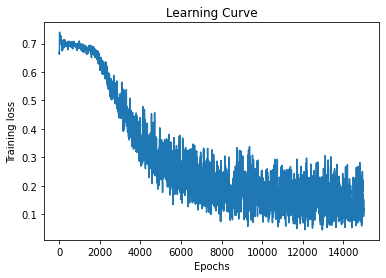

In [5]:
no_epochs = 15000
show_after = 1000
X, y, n_classes = generate_data(n_classes=5, n_features=3*3)
data_euclidean = label_to_data(X, y, n_classes)
plot_accuracy_no_write = []
plot_loss = []
for epoch in range(no_epochs):
    x, y, pred, loss = nn.run_episodes(data_euclidean, create_euclidean_dataset, 
                                       update_dataset=True, MANN=True, LSTM=True)
    accuracy_dict = nn.accuracy(pred, y)
    correct_preds = 0
    for a, b in accuracy_dict.items():
            correct_preds+=sum(b)
    plot_accuracy_no_write.append(correct_preds/(nn.ways*nn.shots))
    plot_loss.append(loss.item())
    if epoch%show_after == 0:
        print(f"Epoch %.4d:  Loss = %f Avg Acc = %f" % (epoch, loss.item(),
                                                    correct_preds/(nn.ways*nn.shots)))
fig1, ax1 = plt.subplots()
ax1.plot(smooth(plot_loss))
ax1.set_title('Learning Curve')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Training loss")

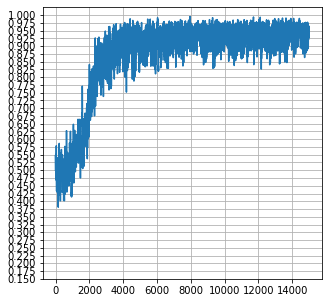

In [6]:
fg, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(smooth(plot_accuracy_no_write, 0.90))
ax.set_yticks(np.arange(0.15, 1.01, step=0.025))
ax.grid(True)

# MANN 

In [7]:
class neural_network(torch.nn.Module):
    def __init__(self, feature_size=5*4, hidden_size=26, ways = 0, shots=0, mem=(20, 26), nreads=2, batch=1):
        super(neural_network, self).__init__()
        self.l1 = torch.nn.LSTM(input_size = feature_size + ways, hidden_size = hidden_size).to(device)
        self.d0 = torch.nn.Linear(feature_size + ways, hidden_size).to(device)
        self.d1 = torch.nn.Linear(hidden_size + nreads*mem[-1], ways).to(device)
        self.kr = torch.nn.Linear(2*hidden_size, mem[-1] * nreads).to(device)
        self.kw = torch.nn.Linear(2*hidden_size, mem[-1] * nreads).to(device)
        self.alpha = torch.nn.Linear(2*hidden_size, mem[0]).to(device)
        self.feature_size = feature_size
        self.ways = ways
        self.shots = shots
        self.hidden_size = hidden_size
        self.stored_dataset = None
        self.mem = mem
        self.nreads = nreads
        self.batch = batch
        self.optimizer = torch.optim.RMSprop(self.parameters(), lr=5e-5, momentum=0.9)
        self.criterion = torch.nn.NLLLoss()

    def backprop(self, Y, labels):
        loss = self.criterion(Y, labels)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss

    def forward(self, X, g, MANN, LSTM, wu, wr, lstmh,  lstmc, memory):
        if LSTM:
            op, (lstmh,  lstmc) = self.l1(X, (lstmh,  lstmc)) # shape=> [1, batch, hidden_size]
        else:
            lstmh = self.d0(X[-1].unsqueeze(0))
        if MANN:
            key = torch.cat((lstmh.reshape(self.batch, -1),  lstmc.reshape(self.batch, -1)), dim=1)# shape => [batch, 2*hidden_size]
            #least recently used
            wlu = wu.clone().detach() # shape => [batch, slots, nreads]
            k_sm_wu = wu.sort(dim=1)[1] # shape => [batch, slots, nreads]
            rem_indx = (k_sm_wu < self.nreads)
            wlu[rem_indx] = 1
            wlu[~rem_indx] = 0

            #write
            write_key = torch.tanh(self.kw(key)).reshape(self.batch, self.nreads, -1) #shape => [batch, nreads, mem_size]
            sigma = torch.tanh(self.alpha(key)) #shape => [batch, slots]
            ww = (sigma*(wr.permute(2,0,1)) + (1-sigma)*(wlu.permute(2,0,1))).permute(1,2,0) # shape => [batch, slots, nreads]
            memory = memory +ww@write_key  #shape => [batch, slots, mem_size]
            #read
            read_key = torch.tanh(self.kr(key)).reshape(self.batch, self.nreads, -1)  #shape => [batch, nreads, mem_size]
            read_key_norm = torch.sqrt(torch.sum(torch.square(read_key), dim=-1)) #shape => [batch, nreads]
            memory_norm = torch.sqrt(torch.sum(torch.square(memory), dim=[1,-1])) # shape => [batch]
            dist_prod = ((read_key_norm.permute(1,0))* memory_norm).permute(1,0) # shape => [batch, nreads]

            z = memory@(read_key.permute((0,2,1))) #shape => [batch, slots, nreads]
            z = (z.permute(1,0,2)/dist_prod).permute(1,0,2) #shape => [batch, slots, nreads]
            wr = torch.nn.functional.softmax(z, dim=1) #shape => [batch, slots, nreads]
            rt = wr.permute((0,2,1))@memory #shape => [batch, nreads, mem_size]

            wu = g*wu + wr + ww # shape => [batch, slots, nreads]
        else:
            rt = torch.rand((self.batch, self.nreads, memory.size()[-1]))
        y_lstm_1_last = torch.cat((lstmh.reshape(self.batch, -1), rt.reshape(self.batch, -1)), dim=1) # shape => [batch,  hidden_size + nreads*mem_size]
        y_d1 = torch.nn.functional.relu(self.d1(y_lstm_1_last)) # shape => [batch, ways]
        pred = torch.nn.functional.log_softmax(y_d1, dim=-1) #shape => [batch, ways]
        return pred, wu, wr, lstmh,  lstmc, memory

    def batched_training(self, X, y_test, g, MANN, LSTM, train):
        memory = 1e-6*torch.ones(self.batch, *self.mem).to(device) # shape => [batch, slots, mem_size]
        wr = torch.randint(0, 2,(self.batch, self.mem[0], self.nreads)).to(device) # shape => [batch, slots, nreads]
        wu = torch.randint(0, 2,(self.batch, self.mem[0], self.nreads)) .to(device)# shape => [batch, slots, nreads]
        lstmh,  lstmc = torch.zeros((1,self.batch,self.hidden_size)).to(device), torch.zeros((1,self.batch,self.hidden_size)).to(device) # shape => [1, batch, hidden_state]
        train_loss = 0
        y_batch = torch.empty((self.batch, 0, self.ways)).to(device)
        for index in range(0, X.size()[0], 1):
            x = X[index: index + 1] #shape => [1, batch, features]
            y, wu, ww, lstmh, lstmc, memory = self.forward(x, g, MANN, LSTM, wu, wr, lstmh,  lstmc, memory)
            y_batch = torch.cat((y_batch, y.unsqueeze(1)), dim=1)  #shape => [shots*ways, batch, ways]
        if train:
            train_loss = self.backprop(y_batch.reshape(-1, self.ways), y_test. reshape(-1))
        return train_loss, y_batch

    def run_episodes (self, data, task_creator, MANN, LSTM, classes, update_dataset = True, train=True):
        if self.stored_dataset == None or update_dataset:
            self.stored_dataset = task_creator(data, self.ways, self.shots, self.batch, classes)
        data_train_x, data_train_y = self.stored_dataset
        data_train_x = torch.from_numpy(data_train_x).to(device) # shape => [batch, (shotsxways), featuresX, featuresY]
        data_train_y = torch.from_numpy(data_train_y).to(device) # shape => [batch, (shotsxways)]
        y_test = data_train_y # shape => [batch, (shotsxways)]
        batch_X = torch.empty((self.ways*self.shots, 0, self.feature_size + self.ways)).to(device)
        for cur_batch in range(self.batch):
            y_prev = torch.tensor([0]).to(device) #shape = [batch]
            X = torch.empty((0, self.feature_size + self.ways)).to(device)
            for index, curr_x in enumerate(data_train_x[cur_batch]):
                y_prev_henc = torch.eye(self.ways).to(device) # shape => [ways, ways]
                y_prev_henc = y_prev_henc[y_prev].squeeze() # shape => [ways]
                flattened_x = curr_x.reshape(-1) # shape => [features]
                curr_X = torch.cat((flattened_x, y_prev_henc)).reshape(1, -1) # shape => [1, features + ways]
                X = torch.cat((X, curr_X)) # shape => [(shotsxways), features]
                y_prev = data_train_y[0][index] # shape => scalar
            X = torch.unsqueeze(X, 1) #shape => [(shotsxways), 1, features]
            X = X.float()
            batch_X = torch.cat((batch_X, X), dim=1) #shape => [(shotsxways), batch, features]
        episode_loss, pred= self.batched_training(batch_X, y_test, 0.95, MANN, LSTM, train)
        return X, y_test, torch.exp(pred), episode_loss

    def accuracy(self, y_pred, labels):
        prev_labels = {}
        acc_dict = {}
        y_pred = y_pred.detach().numpy()
        labels = labels.detach().numpy()
        for index, label in enumerate(labels):
            pred_dec = np.argmax(y_pred[index]).item()
            label_dec = labels[index]
            if prev_labels.get(label_dec, None)  != None:
                prev_labels[label_dec] += 1
                if pred_dec == label_dec:
                    acc_dict[label_dec].append(1)
                else:
                    acc_dict[label_dec].append(0)
            else:
                prev_labels[label_dec] = 1
                if pred_dec == label_dec:
                    acc_dict[label_dec] = [1]
                else:
                    acc_dict[label_dec] = [0]
        return acc_dict

nn = neural_network(ways = 2, shots = 5)
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
print(count_parameters(nn))
print(nn)

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
| l1.weight_ih_l0 |    2288    |
| l1.weight_hh_l0 |    2704    |
|  l1.bias_ih_l0  |    104     |
|  l1.bias_hh_l0  |    104     |
|    d0.weight    |    572     |
|     d0.bias     |     26     |
|    d1.weight    |    156     |
|     d1.bias     |     2      |
|    kr.weight    |    2704    |
|     kr.bias     |     52     |
|    kw.weight    |    2704    |
|     kw.bias     |     52     |
|   alpha.weight  |    1040    |
|    alpha.bias   |     20     |
+-----------------+------------+
Total Trainable Params: 12528
12528
neural_network(
  (l1): LSTM(22, 26)
  (d0): Linear(in_features=22, out_features=26, bias=True)
  (d1): Linear(in_features=78, out_features=2, bias=True)
  (kr): Linear(in_features=52, out_features=52, bias=True)
  (kw): Linear(in_features=52, out_features=52, bias=True)
  (alpha): Linear(in_features=52, out_features=20, bias=True)
  (criterion): NLLLoss()
)


Epoch 0000:  Loss=0.687656, Avg Acc=0.750000
Epoch 1000:  Loss=0.719285, Avg Acc=0.500000
Epoch 2000:  Loss=0.725966, Avg Acc=0.500000
Epoch 3000:  Loss=0.653588, Avg Acc=0.500000
Epoch 4000:  Loss=0.593964, Avg Acc=0.625000
Epoch 5000:  Loss=0.683589, Avg Acc=0.625000
Epoch 6000:  Loss=0.593967, Avg Acc=0.625000
Epoch 7000:  Loss=0.535555, Avg Acc=0.750000
Epoch 8000:  Loss=0.649073, Avg Acc=0.500000
Epoch 9000:  Loss=0.503992, Avg Acc=0.750000
Epoch 10000:  Loss=0.646401, Avg Acc=0.500000
Epoch 11000:  Loss=0.614490, Avg Acc=0.625000
Epoch 12000:  Loss=0.650724, Avg Acc=0.625000
Epoch 13000:  Loss=0.687716, Avg Acc=0.625000
Epoch 14000:  Loss=0.438805, Avg Acc=0.625000
Epoch 15000:  Loss=0.292297, Avg Acc=0.875000
Epoch 16000:  Loss=0.651261, Avg Acc=0.750000
Epoch 17000:  Loss=0.433349, Avg Acc=0.875000
Epoch 18000:  Loss=0.645952, Avg Acc=0.500000
Epoch 19000:  Loss=0.605402, Avg Acc=0.875000
Epoch 20000:  Loss=0.674055, Avg Acc=0.750000
Epoch 21000:  Loss=0.372754, Avg Acc=0.75000

Text(0, 0.5, 'Training loss')

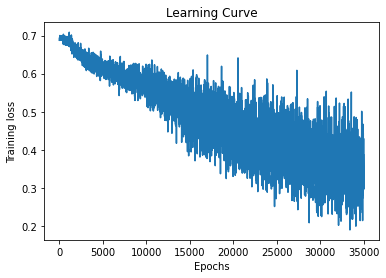

In [9]:
no_epochs = 35000
show_after = 1000
X, y, n_classes = generate_data(n_classes=7, n_features=5*4)
data_euclidean = label_to_data(X, y, n_classes)
plot_accuracy = []
plot_loss = []
acc_on = (1,5)
for epoch in range(no_epochs):
    x, y, pred, loss = nn.run_episodes(data_euclidean, create_euclidean_dataset, update_dataset=True, MANN=True, LSTM=True, classes=(0, 4))
    accuracy_dict = nn.accuracy(pred.reshape(-1, nn.ways), y. reshape(-1))
    correct_preds = 0
    for a, b in accuracy_dict.items():
            correct_preds+=sum(b[acc_on[0]:acc_on[1]])
    plot_accuracy.append(correct_preds/(nn.ways*(acc_on[1]-acc_on[0])*nn.batch))
    plot_loss.append(loss.item())
    if epoch%show_after == 0:
        curr_lr = nn.optimizer.param_groups[0]['lr']
        print(f"Epoch %.4d:  Loss=%f, Avg Acc=%f"%(epoch, loss.item(), 
        (correct_preds/(nn.ways*(acc_on[1]-acc_on[0])*nn.batch))))
fig1, ax1 = plt.subplots()
ax1.plot(smooth(plot_loss))
ax1.set_title('Learning Curve')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Training loss")

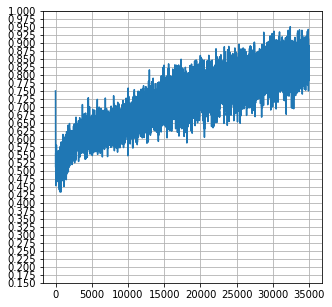

In [10]:
fg, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(smooth(plot_accuracy, 0.90))
ax.set_yticks(np.arange(0.15, 1.01, step=0.025))
ax.grid(True)

#META-TESTING

0 accuracy=0.900000
1000 accuracy=1.000000
2000 accuracy=0.900000
3000 accuracy=0.700000


Text(0, 0.5, 'testaccuracy')

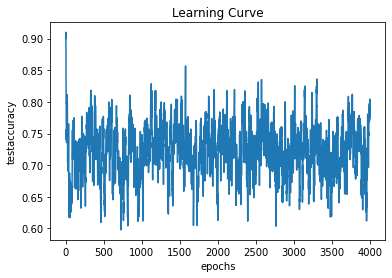

In [11]:
no_epochs = 4000
show_after = 1000
plot_accuracy_test = []
acc_on = (0,5)
for epoch in range(no_epochs):
    x, y, pred, loss = nn.run_episodes(data_euclidean, create_euclidean_dataset,update_dataset=True,
    MANN=True, LSTM=True, train=False, classes=(2, 6))
    accuracy_dict = nn.accuracy(pred.reshape(-1, nn.ways), y. reshape(-1))
    correct_preds = 0
    for a, b in accuracy_dict.items():
            correct_preds+=sum(b[acc_on[0]:acc_on[1]])
    plot_accuracy_test.append(correct_preds/(nn.ways*(acc_on[1]-acc_on[0])*nn.batch))
    if epoch%show_after == 0:
        print(epoch, f"accuracy=%f"%( 
        (correct_preds/(nn.ways*(acc_on[1]-acc_on[0])*nn.batch))))
fig2, ax2 = plt.subplots()
ax2.plot(smooth(plot_accuracy_test))
ax2.set_title('Learning Curve')
ax2.set_xlabel("epochs")
ax2.set_ylabel("testaccuracy")

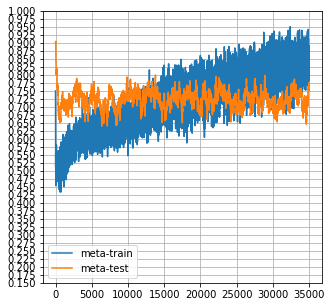

In [12]:
fg, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(smooth(plot_accuracy, 0.90), label='meta-train')
ax.plot(np.array(smooth(plot_accuracy_test, 0.95)) \
[np.linspace(0, len(plot_accuracy_test)-1, len(plot_accuracy), dtype='int')], label='meta-test')
ax.set_yticks(np.arange(0.15, 1.01, step=0.025))
ax.legend(loc='best')
ax.grid(True)

#CNP

In [13]:
class MLP(torch.nn.Module):
    def __init__(self,dims=[5,3,2],task='classification',lr=1e-3):
        super(MLP,self).__init__()
        self.dims=dims
        self.n = len(self.dims)-1
        self.task=task
        self.layers=torch.nn.ModuleList()
        for i in range(self.n-1):
            self.layers.append(torch.nn.Linear(dims[i],dims[i+1]))
            self.layers.append(torch.nn.ReLU())
        if task=='classification': 
            self.layers.append(torch.nn.Linear(dims[i+1],dims[i+2]))
            self.layers.append(torch.nn.LogSoftmax(dim=1))
        elif task=='regression': 
            self.layers.append(torch.nn.Linear(dims[i+1],dims[i+2]))
            self.layers.append(torch.nn.Linear(dims[i+2],1))
        else: self.layers.append(torch.nn.Linear(dims[i+1],dims[i+2]))
        self.optimizer = torch.optim.Adam(self.parameters(),lr=lr)
    def forward(self,x):
        for l in self.layers:
            x = l(x)
        return(x)

class CNP(torch.nn.Module):
    def __init__(self,n_features=1,dims=[32,32],n_classes=2,lr=1e-4):
        super(CNP,self).__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        dimL1 = [n_features]+dims
        dimL2=[n_features+n_classes*dims[-1]]+dims+[n_classes]
        self.mlp1 = MLP(dims=dimL1,task='embedding')
        self.mlp2 = MLP(dims=dimL2)
        self.optimizer=torch.optim.Adam(self.parameters(),lr=lr)
    def adapt(self,X,y):
        R = self.mlp1(X)
        m = torch.eye(self.n_classes)[y].transpose(0,1)/self.n_classes
        r = (m@R).flatten().unsqueeze(0)
        #r = (R.sum(dim=0)/X.shape[0]).unsqueeze(0)
        return r
    def forward(self,Y,r):
        rr = r.repeat(Y.shape[0],1)
        p = self.mlp2(torch.cat((Y,rr),dim=1))
        return p

def accuracy(Net,X_test,y_test,h,verbose=True):
    m = X_test.shape[0]
    y_pred = Net(X_test,h)
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_test).float().sum().item()
    if verbose: print(correct,m)
    accuracy = correct/m
    return accuracy

In [14]:
shots,ways = 2*5, 2
net = CNP(n_features=20,n_classes=ways,dims=[32,64,32],lr=1e-4)
print(count_parameters(net))
lossfn = torch.nn.NLLLoss()
meta_train_kloader=create_euclidean_dataset
meta_test_kloader=create_euclidean_dataset
cnp_train_acc = []
cnp_test_acc_arr = []

+----------------------+------------+
|       Modules        | Parameters |
+----------------------+------------+
| mlp1.layers.0.weight |    640     |
|  mlp1.layers.0.bias  |     32     |
| mlp1.layers.2.weight |    2048    |
|  mlp1.layers.2.bias  |     64     |
| mlp1.layers.4.weight |    2048    |
|  mlp1.layers.4.bias  |     32     |
| mlp2.layers.0.weight |    2688    |
|  mlp2.layers.0.bias  |     32     |
| mlp2.layers.2.weight |    2048    |
|  mlp2.layers.2.bias  |     64     |
| mlp2.layers.4.weight |    2048    |
|  mlp2.layers.4.bias  |     32     |
| mlp2.layers.6.weight |     64     |
|  mlp2.layers.6.bias  |     2      |
+----------------------+------------+
Total Trainable Params: 11842
11842


In [15]:
epoch=0
n_epochs=1000
task_count=10
while epoch<n_epochs:
    test_loss = 0.0
    test_acc = 0.0
    #Sample and train on a task
    for task in range(task_count):
        x,y = meta_train_kloader(data_euclidean, ways, shots, 1, classes=(0, 4))
        d_train = [torch.tensor(x.squeeze()[:ways*shots//2,:]).float(), torch.tensor(y.squeeze()[:ways*shots//2])]
        d_test =  [torch.tensor(x.squeeze()[ways*shots//2:,:]).float(), torch.tensor(y.squeeze()[ways*shots//2:])]
        rp = torch.randperm(d_train[1].shape[0])
        d_train0=d_train[0][rp]
        d_train1=d_train[1][rp]
        x_tr = d_train0
        d_tr = x_tr 
        h = net.adapt(d_tr,d_train1)
        rp1 = torch.randperm(d_test[1].shape[0])
        d_test0=d_test[0][rp1]
        d_test1=d_test[1][rp1]
        x_ts = d_test0
        y_ts_sh = torch.zeros(x_ts.shape[0],ways)
        d_ts = x_ts 
        test_preds = net(d_ts,h)
        train_preds = net(d_tr,h)
        # Accumulate losses over tasks - note train and test loss both included
        test_loss += lossfn(test_preds,d_test1)+lossfn(train_preds,d_train1)
        net.eval()
        test_acc += accuracy(net,d_ts,d_test1,h,verbose=False)
        net.train()
    #Update the network weights
    print('Epoch  % 2d Loss: %f Avg Acc: %f'%(epoch,test_loss/task_count,test_acc/task_count))
    cnp_train_acc.append(test_acc/task_count)
    net.optimizer.zero_grad()
    test_loss.backward()
    net.optimizer.step()
    epoch+=1

Epoch   0 Loss: 1.407986 Avg Acc: 0.460000
Epoch   1 Loss: 1.420035 Avg Acc: 0.500000
Epoch   2 Loss: 1.409170 Avg Acc: 0.520000
Epoch   3 Loss: 1.416245 Avg Acc: 0.460000
Epoch   4 Loss: 1.411292 Avg Acc: 0.520000
Epoch   5 Loss: 1.402699 Avg Acc: 0.520000
Epoch   6 Loss: 1.404329 Avg Acc: 0.510000
Epoch   7 Loss: 1.403731 Avg Acc: 0.510000
Epoch   8 Loss: 1.402278 Avg Acc: 0.490000
Epoch   9 Loss: 1.403483 Avg Acc: 0.440000
Epoch   10 Loss: 1.402830 Avg Acc: 0.480000
Epoch   11 Loss: 1.399577 Avg Acc: 0.520000
Epoch   12 Loss: 1.402317 Avg Acc: 0.510000
Epoch   13 Loss: 1.403495 Avg Acc: 0.470000
Epoch   14 Loss: 1.408690 Avg Acc: 0.490000
Epoch   15 Loss: 1.406111 Avg Acc: 0.550000
Epoch   16 Loss: 1.406712 Avg Acc: 0.470000
Epoch   17 Loss: 1.401602 Avg Acc: 0.520000
Epoch   18 Loss: 1.399513 Avg Acc: 0.540000
Epoch   19 Loss: 1.399791 Avg Acc: 0.540000
Epoch   20 Loss: 1.392641 Avg Acc: 0.480000
Epoch   21 Loss: 1.398766 Avg Acc: 0.500000
Epoch   22 Loss: 1.406010 Avg Acc: 0.52000

In [16]:
epoch=0
n_epochs=1000
task_count=10
while epoch<n_epochs:
    test_loss = 0.0
    test_acc = 0.0
    # Sample and train on a task
    for task in range(task_count):
        x,y = meta_test_kloader(data_euclidean, ways, shots, 1, classes=(2,6))
        d_train = [torch.tensor(x.squeeze()[:ways*shots//2,:]).float(), torch.tensor(y.squeeze()[:ways*shots//2])]
        d_test =  [torch.tensor(x.squeeze()[ways*shots//2:,:]).float(), torch.tensor(y.squeeze()[ways*shots//2:])]
        x_tr = d_train[0]
        y_tr_sh = torch.cat((torch.zeros(1,ways),torch.eye(ways)[d_train[1][1:]]))
        d_tr = x_tr 
        h=net.adapt(d_tr,d_train[1])
        x_ts = d_test[0]
        y_ts_sh = torch.zeros(x_ts.shape[0],ways)
        d_ts = x_ts
        test_preds = net(d_ts,h)
        test_acc += accuracy(net,d_ts,d_test[1],h,verbose=False)
        # Done with a task
    cnp_test_acc_arr.append(test_acc/task_count)
    epoch+=1

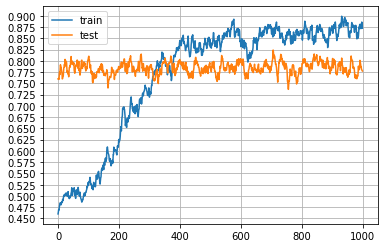

In [17]:
fg, ax= plt.subplots()
ax.set_yticks(np.arange(0.10, 1.01, step=0.025))
ax.plot(smooth(cnp_train_acc, 0.9), label ='train')
ax.plot(smooth(cnp_test_acc_arr, 0.9), label='test')
ax.grid(True)
ax.legend(loc='best')

#MAML

In [19]:
def accuracy(Net,X_test,y_test,verbose=True):
    Net.eval()
    m = X_test.shape[0]
    y_pred = Net(X_test)
    predicted = torch.max(y_pred, 1)[1]
    correct = (predicted == y_test).float().sum().item()
    if verbose: print(correct,m)
    accuracy = correct/m
    Net.train()
    return accuracy

In [20]:
shots,ways = 2*5,2
net = MLP(dims=[20,64,32,ways])
maml = l2l.algorithms.MAML(net, lr=1e-2)
optimizer = torch.optim.Adam(maml.parameters(),lr=5e-3)
lossfn = torch.nn.NLLLoss()
meta_train_kloader=create_euclidean_dataset
maml_train_acc_arr = []
maml_test_acc_arr = []

In [21]:
n_epochs=200
task_count=50
fas = 1
epoch=0
while epoch<n_epochs:
    adapt_loss = 0.0
    test_acc = 0.0
    # Sample and train on a task
    for task in range(task_count):
        x,y = meta_train_kloader(data_euclidean, ways, shots, 1, classes=(0,4))
        d_train = [torch.tensor(x.squeeze()[:ways*shots//2,:]).float(), torch.tensor(y.squeeze()[:ways*shots//2])]
        d_test = [torch.tensor(x.squeeze()[ways*shots//2:,:]).float(), torch.tensor(y.squeeze()[ways*shots//2:])]
        learner = maml.clone()
        for fas_step in range(fas):
            train_preds = learner(d_train[0])
            train_loss = lossfn(train_preds,d_train[1])
            learner.adapt(train_loss)
        test_preds = learner(d_test[0])
        adapt_loss += lossfn(test_preds,d_test[1])
        learner.eval()
        test_acc += accuracy(learner,d_test[0],d_test[1],verbose=False)
        learner.train()
        # Done with a task
    # Update main network
    print('Epoch  %2d:  Loss=%f Avg Acc=%f'%(epoch,adapt_loss/task_count,test_acc/task_count))
    maml_train_acc_arr.append(test_acc/task_count)
    optimizer.zero_grad()
    total_loss = adapt_loss
    total_loss.backward()
    optimizer.step()
    epoch+=1

Epoch   0:  Loss=0.689982 Avg Acc=0.530000
Epoch   1:  Loss=0.701821 Avg Acc=0.484000
Epoch   2:  Loss=0.691538 Avg Acc=0.540000
Epoch   3:  Loss=0.710666 Avg Acc=0.502000
Epoch   4:  Loss=0.671073 Avg Acc=0.560000
Epoch   5:  Loss=0.708751 Avg Acc=0.522000
Epoch   6:  Loss=0.694275 Avg Acc=0.558000
Epoch   7:  Loss=0.686563 Avg Acc=0.546000
Epoch   8:  Loss=0.681171 Avg Acc=0.542000
Epoch   9:  Loss=0.692920 Avg Acc=0.528000
Epoch  10:  Loss=0.690106 Avg Acc=0.538000
Epoch  11:  Loss=0.664309 Avg Acc=0.620000
Epoch  12:  Loss=0.686301 Avg Acc=0.546000
Epoch  13:  Loss=0.701563 Avg Acc=0.466000
Epoch  14:  Loss=0.687826 Avg Acc=0.526000
Epoch  15:  Loss=0.680757 Avg Acc=0.560000
Epoch  16:  Loss=0.678678 Avg Acc=0.552000
Epoch  17:  Loss=0.665404 Avg Acc=0.616000
Epoch  18:  Loss=0.678138 Avg Acc=0.552000
Epoch  19:  Loss=0.668346 Avg Acc=0.582000
Epoch  20:  Loss=0.663325 Avg Acc=0.560000
Epoch  21:  Loss=0.649876 Avg Acc=0.650000
Epoch  22:  Loss=0.659676 Avg Acc=0.588000
Epoch  23: 

In [22]:
n_epochs=200
task_count=50
adapt_steps = 2
epoch=0
while epoch<n_epochs:
    test_acc = 0.0
    meta_test_kloader=create_euclidean_dataset
    test_acc = 0.0
    maml.eval()
    # Sample and train on a task
    for task in range(task_count):
        x,y = meta_train_kloader(data_euclidean, ways, shots, 1, classes=(2,6))
        d_train = [torch.tensor(x.squeeze()[:ways*shots//2,:]).float(), torch.tensor(y.squeeze()[:ways*shots//2])]
        d_test = [torch.tensor(x.squeeze()[ways*shots//2:,:]).float(), torch.tensor(y.squeeze()[ways*shots//2:])]
        learner = maml.clone()
        learner.eval()
        for adapt_step in range(adapt_steps):
            train_preds = learner(d_train[0])
            train_loss = lossfn(train_preds,d_train[1])
            learner.adapt(train_loss)
        test_preds = learner(d_test[0])
        test_acc += accuracy(learner,d_test[0],d_test[1],verbose=False)
        # Done with a task
    learner.train()
    maml_test_acc_arr.append(test_acc/task_count)
    epoch += 1

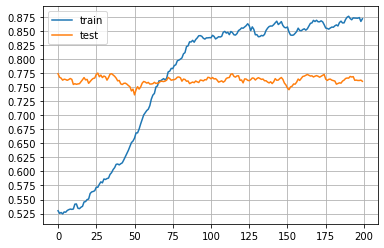

In [23]:
fg, ax= plt.subplots()
ax.set_yticks(np.arange(0.10, 1.01, step=0.025))
ax.plot(smooth(maml_train_acc_arr, 0.9), label ='train')
ax.plot(smooth(maml_test_acc_arr, 0.9), label='test')
ax.grid(True)
ax.legend(loc='best')

# MATCHING NETWORKS

In [24]:
class Cos(torch.nn.Module):
    def __init__(self,dims=[20,32,32]):
        super(Cos,self).__init__()
    def forward(self,target,ss):
        # compute cosine distances between 
        # target (batch,embedding_dim) and support set ss (ss_size,embedding_dim)
        # return (batch,ss_size)
        target_normed = torch.nn.functional.normalize(target,p=2,dim=1)
        # shape of target_normed will be (batch,1,embedding_dim)
        ss_normed = torch.nn.functional.normalize(ss,p=2,dim=1).permute(1,0)
        similarities = torch.mm(target_normed,ss_normed)
        # result will be (batch,ss_size)
        return similarities
class MAN(torch.nn.Module):
    def __init__(self,dims=[20,32,32],n_classes=2,lr=1e-3):
        super(MAN,self).__init__()
        self.n_classes = n_classes
        self.mlp = MLP(dims=dims,task='embedding')
        self.cos = Cos()
        self.attn = torch.nn.Softmax(dim=1)
        self.optimizer = torch.optim.Adam(self.parameters(),lr=lr)
    def forward(self,X,d_train):
        # X = (batch,n_features)
        (x_tr,y_tr) = d_train
        # x_tr = (ss_size,n_features), y_tr = (ss_size)
        ss_e = self.mlp(x_tr)
        X_e = self.mlp(X)
        sims = self.cos(X_e,ss_e)
        # size (batch,ss_size)
        attn_wts = self.attn(sims)
        y_h = torch.eye(self.n_classes)[y_tr]
        # y_h = one-hot version of y_tr = (ss_size,n_classes)
        preds = attn_wts@y_h
        return preds
def accuracy(Net,X_test,y_test,h,verbose=True):
    m = X_test.shape[0]
    y_pred = Net(X_test,h)
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_test).float().sum().item()
    if verbose: print(correct,m)
    accuracy = correct/m
    return accuracy

In [25]:
shots,ways = 2*5,2
net = MAN(n_classes=ways,dims=[20,64,32],lr=1e-4)
lossfn = torch.nn.NLLLoss()
meta_train_kloader = create_euclidean_dataset
match_train_acc_arr, match_test_acc_arr = [],[]

In [26]:
epoch=0
n_epochs=500
task_count=50
while epoch<n_epochs:
    test_loss = 0.0
    test_acc = 0.0
    # Sample and train on a task
    for task in range(task_count):
        x,y = meta_train_kloader(data_euclidean, ways, shots, 1, classes=(0,4))
        d_train = [torch.tensor(x.squeeze()[:ways*shots//2,:]).float(), torch.tensor(y.squeeze()[:ways*shots//2])]
        d_test = [torch.tensor(x.squeeze()[ways*shots//2:,:]).float(), torch.tensor(y.squeeze()[ways*shots//2:])]
        rp = torch.randperm(d_train[1].shape[0])
        d_train0=d_train[0][rp]
        d_train1=d_train[1][rp]
        x_tr = d_train0
        d_tr = x_tr 
        rp1 = torch.randperm(d_test[1].shape[0])
        d_test0=d_test[0][rp1]
        d_test1=d_test[1][rp1]
        x_ts = d_test0
        d_ts = x_ts 
        test_preds = net(d_ts,(x_tr,d_train1))
        #train_preds = net(d_tr,h)
        # Accumulate losses over tasks - note train and test loss both included
        test_loss += lossfn(test_preds,d_test1)
        net.eval()
        test_acc += accuracy(net,d_ts,d_test1,(x_tr,d_train1),verbose=False)
        net.train()
    #Update the network weights
    print('Epoch  % 2d Loss: %f Avg Acc: %2f'%(epoch,test_loss/task_count,test_acc/task_count))
    match_train_acc_arr.append(test_acc/task_count)
    net.optimizer.zero_grad()
    test_loss.backward()
    net.optimizer.step()
    epoch+=1

Epoch   0 Loss: -0.510836 Avg Acc: 0.554000
Epoch   1 Loss: -0.507739 Avg Acc: 0.540000
Epoch   2 Loss: -0.505074 Avg Acc: 0.546000
Epoch   3 Loss: -0.502234 Avg Acc: 0.454000
Epoch   4 Loss: -0.505773 Avg Acc: 0.588000
Epoch   5 Loss: -0.499000 Avg Acc: 0.464000
Epoch   6 Loss: -0.510144 Avg Acc: 0.556000
Epoch   7 Loss: -0.503286 Avg Acc: 0.524000
Epoch   8 Loss: -0.500502 Avg Acc: 0.542000
Epoch   9 Loss: -0.504193 Avg Acc: 0.530000
Epoch   10 Loss: -0.509505 Avg Acc: 0.550000
Epoch   11 Loss: -0.504898 Avg Acc: 0.524000
Epoch   12 Loss: -0.506844 Avg Acc: 0.542000
Epoch   13 Loss: -0.507768 Avg Acc: 0.558000
Epoch   14 Loss: -0.512331 Avg Acc: 0.564000
Epoch   15 Loss: -0.516218 Avg Acc: 0.588000
Epoch   16 Loss: -0.506584 Avg Acc: 0.500000
Epoch   17 Loss: -0.504340 Avg Acc: 0.508000
Epoch   18 Loss: -0.509787 Avg Acc: 0.478000
Epoch   19 Loss: -0.506623 Avg Acc: 0.590000
Epoch   20 Loss: -0.515720 Avg Acc: 0.580000
Epoch   21 Loss: -0.509235 Avg Acc: 0.548000
Epoch   22 Loss: -0.

In [27]:
epoch=0
n_epochs=500
task_count=50
meta_train_kloader = create_euclidean_dataset
while epoch<n_epochs:
    test_loss = 0.0
    test_acc = 0.0
    # Sample and train on a task
    for task in range(task_count):
        x,y = meta_train_kloader(data_euclidean, ways, shots, 1, classes=(2,6))
        d_train = [torch.tensor(x.squeeze()[:ways*shots//2,:]).float(), torch.tensor(y.squeeze()[:ways*shots//2])]
        d_test = [torch.tensor(x.squeeze()[ways*shots//2:,:]).float(), torch.tensor(y.squeeze()[ways*shots//2:])]
        x_tr = d_train[0]
        y_tr_sh = torch.cat((torch.zeros(1,ways),torch.eye(ways)[d_train[1][1:]]))
        d_tr = x_tr #torch.cat((x_tr,y_tr_sh),1)
        x_ts = d_test[0]
        y_ts_sh = torch.zeros(x_ts.shape[0],ways)
        d_ts = x_ts #torch.cat((x_ts,y_ts_sh),1)
        test_preds = net(d_ts,(d_tr,d_train[1]))
        test_acc += accuracy(net,d_ts,d_test[1],(d_tr,d_train[1]),verbose=False)
        # Done with a task
    net.train()
    match_test_acc_arr.append(test_acc/task_count)
    epoch +=1

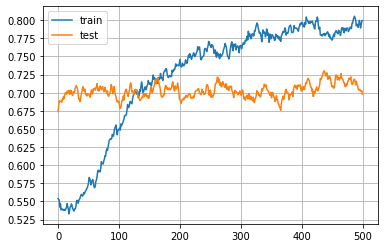

In [28]:
fg, ax= plt.subplots()
ax.set_yticks(np.arange(0.10, 1.01, step=0.025))
ax.plot(smooth(match_train_acc_arr, 0.9), label ='train')
ax.plot(smooth(match_test_acc_arr, 0.9), label='test')
ax.grid(True)
ax.legend(loc='best')

#COMBINED PERFORMANCE

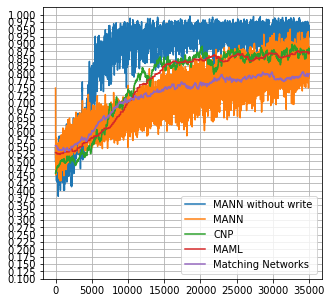

In [39]:
fg, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(np.array(smooth(plot_accuracy_no_write))[np.linspace(0, len(plot_accuracy_no_write)-1, 35000, dtype='int')], label='MANN without write')
ax.plot(np.array(smooth(plot_accuracy))[np.linspace(0, len(plot_accuracy)-1, 35000, dtype='int')], label='MANN')
ax.plot(np.array(smooth(cnp_train_acc))[np.linspace(0, len(cnp_train_acc)-1, 35000, dtype='int')], label='CNP')
ax.plot(np.array(smooth(maml_train_acc_arr))[np.linspace(0, len(maml_train_acc_arr)-1, 35000, dtype='int')], label='MAML')
ax.plot(np.array(smooth(match_train_acc_arr))[np.linspace(0, len(match_train_acc_arr)-1, 35000, dtype='int')], label='Matching Networks')
ax.set_yticks(np.arange(0.1, 1.01, step=0.025))
ax.grid(True)
ax.legend(loc='best')

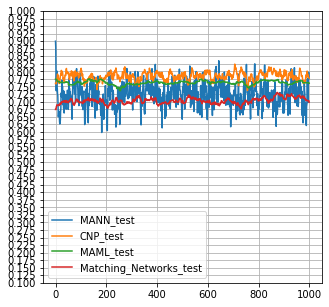

In [37]:
fg, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(np.array(smooth(plot_accuracy_test))[np.linspace(0, len(plot_accuracy_test)-1, 1000, dtype='int')], label='MANN_test')
ax.plot(np.array(smooth(cnp_test_acc_arr))[np.linspace(0, len(cnp_test_acc_arr)-1, 1000, dtype='int')], label='CNP_test')
ax.plot(np.array(smooth(maml_test_acc_arr))[np.linspace(0, len(maml_test_acc_arr)-1, 1000, dtype='int')], label='MAML_test')
ax.plot(np.array(smooth(match_test_acc_arr))[np.linspace(0, len(match_test_acc_arr)-1, 1000, dtype='int')], label='Matching_Networks_test')
ax.set_yticks(np.arange(0.1, 1.01, step=0.025))
ax.grid(True)
ax.legend(loc='best')

#MANN on OMNIGLOT


In [ ]:
new_shape = (28, 28)
imagenet_data_back = tv.datasets.Omniglot('/content/sample_data/Omniglot', download=True, background=True)
imagenet_data_eval = tv.datasets.Omniglot('/content/sample_data/Omniglot', download=True, background=False)

In [ ]:
def image_array(home, im_path, new_shape):
    path = os.path.join(home, im_path)
    main_list = os.listdir(path)
    image_list_main = []
    for folder in main_list:
        char_list = os.listdir(os.path.join(path, folder))
        image_list_folder = []
        for char in char_list:
            img_list = os.listdir(os.path.join(path, folder, char))
            image_list_char = []
            for img in img_list:
                img_arr = Image.open(os.path.join(path, folder, char, img))
                img_arr.thumbnail(new_shape, Image.ANTIALIAS) 
                img_arr = np.asarray(img_arr, dtype=np.float) 
                image_list_char.append(img_arr)
            image_list_folder.append(image_list_char)
        image_list_main.append(np.asarray(image_list_folder))
    return image_list_main
home = '/content/sample_data'
path1 = 'Omniglot/omniglot-py/images_background'
path2 = 'Omniglot/omniglot-py/images_evaluation'
imgs_train = image_array(home, path1, new_shape)
imgs_test = image_array(home, path2, new_shape)

In [ ]:
def create_dataset(imgs, ways, shots, tasks):
    main_list_x = []
    main_list_y = []
    for task in range(tasks):
        task_list_x = []
        task_list_y = []
        for way in range(ways):
            no_langs = len(imgs)
            lang = randint(0, no_langs-1)
            no_chars = imgs[lang].shape[0]
            char = randint(0, no_chars-1)
            no_imgs = imgs[lang][char].shape[0]
            for img in range(shots):
                img_no = randint(0, no_imgs-1)
                cur_img = imgs[lang][char][img_no]
                task_list_x.append(cur_img,)
                task_list_y.append(way)
        size = shots*ways
        indices = np.random.choice(size, size, replace=False)
        task_list_x = np.array(task_list_x)
        task_list_y = np.array(task_list_y)
        task_list_x = task_list_x[indices]
        task_list_y = task_list_y[indices]
        main_list_x.append(task_list_x)
        main_list_y.append(task_list_y)
    return np.array(main_list_x), np.array(main_list_y)

data_train_x, data_train_y = create_dataset(imgs_train, 2, 5, 1)
data_test_x, data_test_y = create_dataset(imgs_test, 2, 5, 1)
print(data_train_x.shape, data_train_y.shape)
for i in range(0,10):
    print(collections.Counter(data_train_y[0]))
    fg, ax = plt.subplots()
    ax.imshow(data_train_x[0][i])
    ax.set_title(data_train_y[0][i])

In [ ]:
no_epochs = 1_00_000
show_after = 100
update = 1
plot_accuracy = []
plot_loss = []
acc_on = (0,5)
for epoch in range(no_epochs):
    x, y, pred, loss = nn.run_episodes(imgs_train, create_dataset, feature_size=28*28, 
    hidden_size=200, ways = 0, shots=0, mem=(128, 40), nreads=2, batch=1)
    if epoch%update:
        continue
    else:
        nn.stored_dataset = None
        #pass
    accuracy_dict = nn.accuracy(pred.reshape(-1, nn.ways), y. reshape(-1))
    correct_preds = 0
    for a, b in accuracy_dict.items():
            correct_preds+=sum(b[acc_on[0]:])
    plot_accuracy.append(correct_preds/(nn.ways*(acc_on[1]-acc_on[0])*nn.batch))
    plot_loss.append(loss.item())
    if epoch%show_after == 0:
        curr_lr = nn.optimizer.param_groups[0]['lr']
        print(f"Epoch=%d"%epoch, f"loss=%f, accuracy=%f"%(loss.item(), 
        (correct_preds/(nn.ways*(acc_on[1]-acc_on[0])*nn.batch))))
        #print(x, y, pred)
        #print(memory)
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
ax1.plot(smooth(plot_loss))
ax2.plot(smooth(plot_accuracy))
ax1.set_title('Learning Curve')
ax2.set_title('Learning Curve')
ax1.set_xlabel("epochs")
ax1.set_ylabel("training loss")
ax2.set_xlabel("epochs")
ax2.set_ylabel("training accuracy")